In [94]:
import pandas as pd
import numpy as np
import hvplot.pandas

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.integrate import simps
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline


In [95]:
#load temperature profile data for MY30
df_30=pd.read_parquet('MY30.parquet.gzip')

In [96]:
#sort the data so that the altitudes are given in ascending order for each (LS, lat) coordinate
df_sorted_30 = df_30.sort_values(by=['LS', 'SCENELATITUDE', 'ALTITUDE'], ascending=[True, False, True])


In [97]:
#save dataframe 
df_sorted_30.to_pickle("dataframe_MCS_30.pkl")


In [98]:
del df_30

In [99]:
#outputs the number of surface temperature data points for each (LS, lat) coordinate
df_30_surftemp_all = df_sorted_30.groupby(['LS', 'SCENELATITUDE', 'SURFACETEMPERATURE'], sort=False).size().reset_index(name='count')


In [100]:
#
g = 3.72  # gravity on Mars (m/s^2)
cp = 846  # specific heat capacity of CO2 (J/kg/K)
dry_adiabatic_lapse_rate = g / cp  # dry adiabatic lapse rate (K/m)

def calculate_cape(temp_profile, z_profile, surface_temp, dry_lapse_rate, kink_alt):
    """
    Function to calculate CAPE based on the environmental temperature lapse rate and the adiabatic lapse rate 
    Arguments:
    - temp_profile: environmental temperature profile (array of temperatures)
    - z_profile: altitude levels corresponding to temp_profile (array of altitudes)
    - surface_temp: surface temperature (for the parcel)
    - dry_lapse_rate: dry adiabatic lapse rate (K/m)
    
    Returns:
    - cape_value: calculated CAPE or None if conditions are not met
    """
    #print('start')
    #if the first temperature value is a nan...
    if np.isnan(temp_profile[0]): 
        
        #...find the index of the first non-nan value
        first_non_nan_idx = np.where(~np.isnan(temp_profile))[0][0]
        
        #check if the corresponding altitude of the first non nan value falls within extrapolation range (0.15-10km)
        if kink_alt < z_profile[first_non_nan_idx] <= 10:
            
            #create new altitude values to interpolate to 
            new_alts = np.linspace(kink_alt, z_profile[first_non_nan_idx], 5)
            #find temperature values corresponding to new altitudes (linear extrapolation down to 0.15 km)
            new_temps = np.interp(new_alts, z_profile[first_non_nan_idx:], temp_profile[first_non_nan_idx:])

            #concatenate new temperatures and altitudes to temp and z profiles starting at non nan value (create new temp profile)
            temp_profile = np.concatenate([new_temps, temp_profile[first_non_nan_idx+1:]])
            z_profile = np.concatenate([new_alts, z_profile[first_non_nan_idx+1:]])
            
            #linearly interpolat to surface temperature
            superadiabat_temps = np.linspace(surface_temp, temp_profile[0], 5)
            superadiabat_alts = np.linspace(0, z_profile[0], 5)
            
            #create new temperature profile
            temp_profile = np.concatenate([superadiabat_temps, temp_profile[1:]])
            z_profile = np.concatenate([superadiabat_alts, z_profile[1:]])
            
        #check if the corresponding altitude of the first non nan value falls within interpolation range (surface-0.15km)    
        elif 0 < z_profile[first_non_nan_idx] < kink_alt: 
            
            #...find the relevant first non-nan temp
            first_non_nan_value = temp_profile[first_non_nan_idx]
            # Count the number of leading NaN values
            nan_count = first_non_nan_idx
            # Generate replacement values using np.linspace (linear interpolation to surface temp)
            replacement_values = np.linspace(surface_temp, first_non_nan_value, nan_count+1)
            
            # Replace the leading NaN values to complete temperature profile
            temp_profile[:nan_count + 1] = replacement_values
            
            z_profile[0] = 0
   
        #only interested in temperatures below 10km (boundary layer)
        elif z_profile[first_non_nan_idx] > 10:
            
            return (None, None, None, None, None, None, None)
    
    #if the first temperature value is not a nan...
    else:
        
        #...and it starts at the surface:
        if z_profile[0] == 0:
            
            temp_profile[0] = surface_temp

        #...but the first altitude value is greater than 10km, we disregard this profile
        elif z_profile[0] > 10:
            
            return (None, None, None, None, None, None, None)
        
        #but if the first altitude value occurs between 0.15 and 10 km...
        elif 0.15 < z_profile[0] <= 10:
            
            #create new altitude values to interpolate to
            new_alts = np.linspace(kink_alt, z_profile[0], 5)
            
            #derive temp values corresponding to new alt values
            new_temps = np.interp(new_alts, z_profile, temp_profile)

            #create new temp profile
            temp_profile = np.concatenate([new_temps, temp_profile[1:]])
            z_profile = np.concatenate([new_alts, z_profile[1:]])

            #linearly interpolate to surface for alts below 0.15km
            superadiabat_temps = np.linspace(surface_temp, temp_profile[0], 5)
            superadiabat_alts = np.linspace(0, z_profile[0], 5)
            
            #create new temp profile
            temp_profile = np.concatenate([superadiabat_temps, temp_profile[1:]])
            z_profile = np.concatenate([superadiabat_alts, z_profile[1:]])

        #...and starts at altitude within superadiabatic layer:
        elif 0 < z_profile[0] < 0.15:
            
            #linearly interpolate to surface 
            superadiabat_temps = np.linspace(surface_temp, temp_profile[0], 5)
            superadiabat_alts = np.linspace(0, z_profile[0], 5)
            
            #create new temp profile
            temp_profile = np.concatenate([superadiabat_temps, temp_profile[1:]])
            z_profile = np.concatenate([superadiabat_alts, z_profile[1:]])

    #valid rows will be where both temp profile is not nan and the z_profile is not nan
    valid_mask = ~np.isnan(temp_profile) & ~np.isnan(z_profile)
    temp_profile = temp_profile[valid_mask]
    z_profile = z_profile[valid_mask]
    
    #from the remaing rows I want to check if there are any duplicates for the altitudes by accident and remove them
    unique_z_profile, indices = np.unique(z_profile, return_index=True)
    z_profile = z_profile[indices]
    temp_profile = temp_profile[indices]
     
    #at this point the temp profiles and z profiles should be nanless at the beginning and interpolated to the surface
    #for further analysis 
    
    #create a smoother curve with more points
    spline = make_interp_spline(z_profile, temp_profile, k=1)  # k=3 for cubic spline

    # Generate new points
    z_profile = np.linspace(z_profile.min(), z_profile.max(), 1000)
    temp_profile = spline(z_profile)

    #find index of altitude closest to 6km and 1m in altitude profile
    index_6km = np.argmin(np.abs(z_profile - 6)) 
    index_1m = np.argmin(np.abs(z_profile - 0.05))    
    
    #find corresponding temperature at 1m altitude
    temp_1m = temp_profile[index_1m]
    
    #calculate the lapse rate of the temp profile
    environmental_lapse = np.gradient(temp_profile, z_profile) #K/km
    
    #convert altitude to meters
    z_profile_m = z_profile * 1000
    
    # Find start and end indices where environmental lapse rate < adiabatic lapse rate
    lfc_indices = np.where(environmental_lapse < (-dry_lapse_rate * 1000))[0]
    
    if lfc_indices.size == 0:
        return (None, None, None, None, None, None, None)  # Return None if no suitable LFC is found

    lfc_idx = lfc_indices[0]
        
    # Set the parcel temperature at the LFC to match the environmental temperature at that altitude (because after this Tenv < Tparcel)
    lfc_temp = temp_profile[lfc_idx]
    
    # Calculate the parcel temperature profile starting from the LFC
    parcel_temp_profile = lfc_temp - dry_lapse_rate * (z_profile_m - z_profile_m[lfc_idx])
    
    #the index at which the parcel temp < env temp
    end_idx = np.where(environmental_lapse[lfc_idx:] > (-dry_lapse_rate * 1000))[0]
    
    # Check if end index is within 10 km, then calculate CAPE
    if end_idx.size > 0:
        
        el_idx = lfc_idx + end_idx[0] #make sure indices start at 0 at surface 
        
        if z_profile[el_idx] <= 10:
            
            # Calculate CAPE over this range
            z_int = z_profile_m[lfc_idx:el_idx + 1] 
            env_int = temp_profile[lfc_idx:el_idx + 1]
            parcel_int = parcel_temp_profile[lfc_idx:el_idx + 1]
            
            # Integrate to calculate CAPE (assumes pressure effects can be neglected for simplicity)
            integrand = (g * (parcel_int - env_int)) / (env_int + 1e-6)
            
            lfc = z_profile[lfc_idx]
            el = z_profile[el_idx]
            cape_value = simps(integrand, z_int)
            
            return (lfc, el, cape_value, z_profile, temp_profile, temp_1m, index_6km)

    return (None, None, None, None, None, None, None)    

In [101]:
# Function to replace leading NaN values only if the list begins with NaNs
#this function ensures that the z-profile that is entered into the calculate_cape function is nan-free and complete

def replace_leading_nans_with_linspace(data):
    data_array = np.array(data)
    
    # Check if the first element is NaN
    if np.isnan(data_array[0]):
        
        # Find the first non-NaN value index
        first_non_nan_idx = np.where(~np.isnan(data_array))[0][0]
        first_non_nan_value = data_array[first_non_nan_idx]

        # Count the number of leading NaN values
        #because indices start at 0, this method makes sense
        nan_count = first_non_nan_idx

        # Generate replacement values using np.linspace
        replacement_values = np.linspace(0, first_non_nan_value, nan_count + 1)

        # Replace the leading NaN values
        data_array[:nan_count + 1] = replacement_values
    
    return data_array


In [102]:
#following three functions are used in the dust devil calculation (available energy to drive vortices = intensity of dust devils)
#equation can be found in Section 4.1.2 of manuscript 

def find_pressure(temp_profile, z_profile, index_6km):
    
    """
    this function calculates the pressure at ~6 km for each temperature profile 
    we need T_prof to be from surface temp to temperature at ~6 km
    we need z prof to be from surface to ~6 km
    """
    if index_6km is None or temp_profile is None or z_profile is None:
        return(np.nan)
    
    else:
        T_prof = temp_profile[0 : index_6km + 1]
        z_prof = (z_profile[0 : index_6km + 1]) * 1000
        
        surface_pressure = 7 * 100 #Pa
        
        g = 3.72 #gravitational acceleration ms-2
        
        R = 188.2  # Jkg-1K-1 - specific gas constant for CO2

        integrand = g / (R * T_prof)

        exponential = simps(integrand, z_prof)
    
        return(surface_pressure * np.exp(-exponential)) #returns pressure in Pa

In [103]:
def calculate_thermal_eff(p_top):
    
    """
    this is the b required to calculate the thermal efficiency eta = 1-b
    chi is the specific heat ratio for CO2 (value from PDS)
    p_top is the pressure at the top of the convective boundary layer taken as 6km (from petrosyan et al. 2011)
    p_surf is from petrosyan et al. 2011 and in hPa = mbar
    """
    
    if p_top is None:
        
        return(np.nan)
    
    else:
        
        p_surf = 7 * 100 #Pa
        chi = 0.2273 

        b_top = (p_surf**(chi+1)) - (p_top**(chi+1))
        b_bot = (p_surf - p_top) * (chi+1) * (p_surf**chi)

        b = b_top/b_bot
        
        return(1-b)

In [104]:
def calculate_sensible_heat_flux(surface_temp, temp_one):
    
    """
    this calculates the surface sensible heat flux needed to find the energy output from the convective heat engine
    - atmospheric density value is from https://nssdc.gsfc.nasa.gov/planetary/factsheet/marsfact.html
    - friction velocity value is from petrosyan et al. 2011
    - assume temperature at near surface to be at 1m 
    """
    
    
    rho = 0.02 #kg/m3 atmospheric density
    cp = 730 #Jkg-1K-1 specific heat capacity 
    u = 0.4 #friction velocity m/s
    
    if temp_one is None:
        return(np.nan)
        
    else:
        del_t = surface_temp - temp_one #K
        #print(del_t)
        return(rho * cp * u * del_t) #W/m2

In [105]:
#number of altitue (temperature) values per [ls,lat] coordinate
chunk_size = 105
total_rows = len(df_sorted_30)

lfc_alt = []
el_alt = []
cape_value = []

valid_profiles = []
dust_devil_heat = []

eta = []
pressure_at_6km = []
sensible_heat = []

# Iterate through chunks of 105 rows
for start in range(0, total_rows, chunk_size):
    
    end = start + chunk_size
    chunk = df_sorted_30.iloc[start:end]
    
    #obtain profiles for each [ls, lat] coordinate from dataframe
    z_profile = chunk['ALTITUDE'].values
    z_profile_parcel = replace_leading_nans_with_linspace(z_profile)
    temp_profile = chunk['TEMPERATURE'].values
    
    surface_temp = chunk['SURFACETEMPERATURE'].iloc[0]
    latitude = chunk['SCENELATITUDE'].iloc[0]
    ls = chunk['LS'].iloc[0]
    
    #run through cape calculation function
    cape_returns = calculate_cape(temp_profile, z_profile_parcel, surface_temp, dry_adiabatic_lapse_rate, 0.15)
    
    lfc_alt.append(cape_returns[0])
    el_alt.append(cape_returns[1])
    cape_value.append(cape_returns[2])
    
    #calculate dust devil intensity using above defined three functions
    sensible_heat_return = calculate_sensible_heat_flux(surface_temp, cape_returns[5])
    sensible_heat.append(sensible_heat_return)
    
    pressure_return = find_pressure(cape_returns[4], cape_returns[3], cape_returns[6])
    pressure_at_6km.append(pressure_return)
    
    thermal_eff = calculate_thermal_eff(pressure_return)
    eta.append(thermal_eff)
    
    if sensible_heat_return is None or thermal_eff is None:
        
        heat_output = np.nan
        
    else:
        
        heat_output = thermal_eff * sensible_heat_return
    
    dust_devil_heat.append(heat_output)

    # Collect valid profiles (where CAPE is not None)
    if cape_returns[2] is not None:
        valid_profiles.append((cape_returns[3], cape_returns[4], cape_returns[0], cape_returns[1], cape_returns[2], latitude, ls, surface_temp))
    
print('done')

done


In [106]:
del df_sorted_30

In [107]:
def plot_profiles(z_profile, temp_profile, parcel_temp_profile, lfc, el, dry_adiabatic_lapse_rate, latitude, ls, cape):
    
    """
    Plot the extrapolated environmental temperature profiles
    and a subplot showing the lapse rate profiles, with CAPE regions highlighted.
    
    Parameters:
    - z_profile: Altitude profile (in km)
    - temp_profile: Environmental temperature profile (in K)
    - lfc: Level of Free Convection altitude (in km)
    - el: Equilibrium Level altitude (in km)
    - dry_adiabatic_lapse_rate: The dry adiabatic lapse rate (K/m)
    """
    
    # Calculate environmental lapse rate
    environmental_lapse_rate = np.gradient(temp_profile, z_profile * 1000)  # Convert km to m for lapse rate #K/m
    adiabatic_lapse_rate_profile = np.full_like(z_profile, -dry_adiabatic_lapse_rate * 1000)  # Convert to K/km
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot temperature profiles on the first subplot
    axs[0].scatter(temp_profile, z_profile, label='Environmental Temp (K)', s=5)
    
    # Set labels and title for the temperature profile plot
    axs[0].set_xlabel('Temperature (K)')
    axs[0].set_ylabel('Altitude (km)')
    axs[0].set_title('Temperature Profiles for Lat = {}, Ls = {}'.format(latitude, ls))
    axs[0].legend(loc='best')
    axs[0].set_ylim(0,3)
    axs[0].grid(True)

    # Plot lapse rate profiles on the second subplot
    axs[1].scatter(environmental_lapse_rate * 1000, z_profile, label='Environmental Lapse Rate (K/km)', s=5)
    axs[1].scatter(adiabatic_lapse_rate_profile, z_profile, label='Adiabatic Lapse Rate (K/km)', s=5)
    
    # Shade CAPE region where parcel temperature > environmental temperature
    cape_region = np.where((z_profile >= lfc) & (z_profile <= el))
    axs[1].fill_betweenx(z_profile[cape_region], (environmental_lapse_rate * 1000)[cape_region], adiabatic_lapse_rate_profile[cape_region],
                         where=adiabatic_lapse_rate_profile[cape_region] > (environmental_lapse_rate * 1000)[cape_region], color='orange', alpha=0.3,
                         label='CAPE Region')

    axs[1].text(-30, 3, f'CAPE = {cape:.2f} J/kg' )
    axs[1].set_ylim(0,3)
    axs[1].set_xlim(-50,10)
    axs[1].set_xlabel('Lapse Rate (K/km)')
    axs[1].set_title('Lapse Rate Profiles')
    axs[1].legend(loc='best')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

0.0


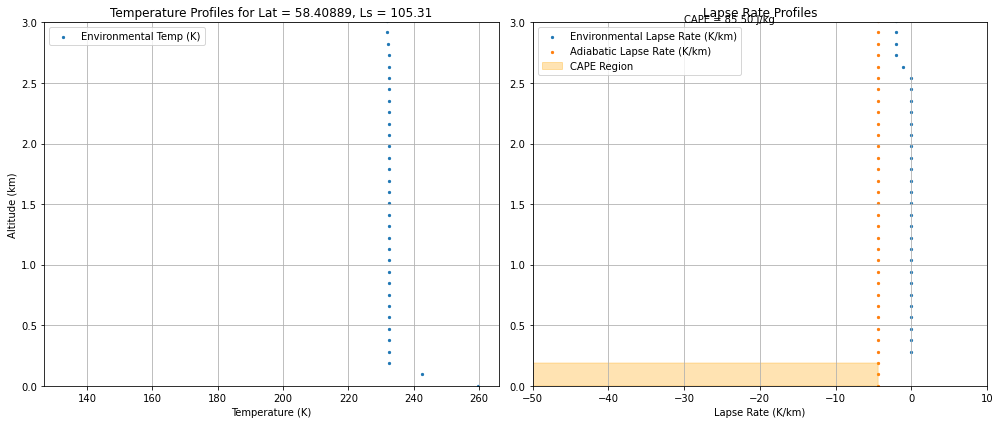

0.0


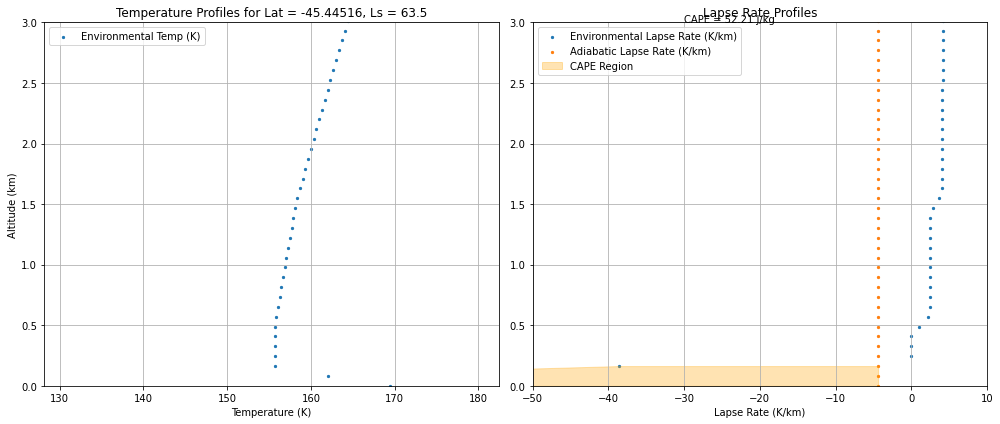

0.0


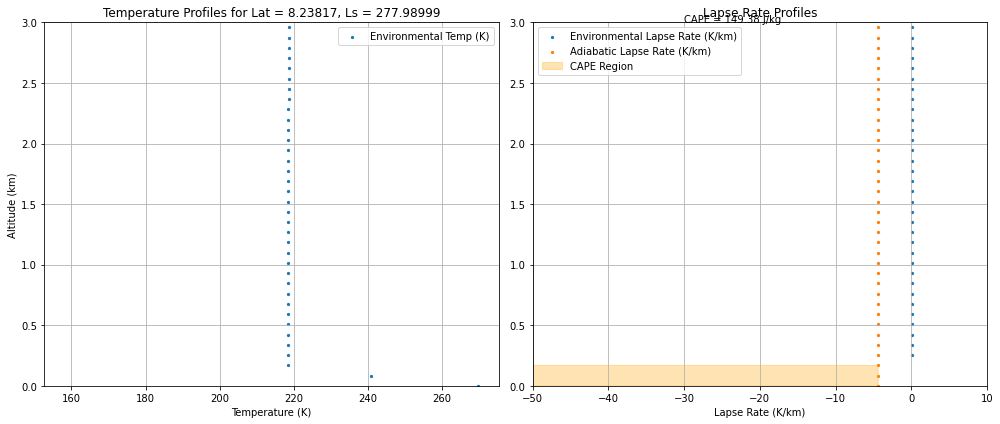

0.0


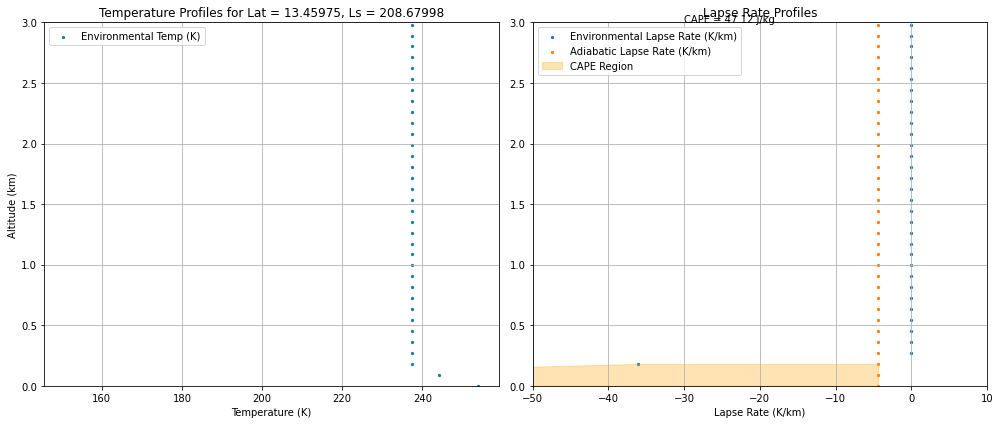

0.0


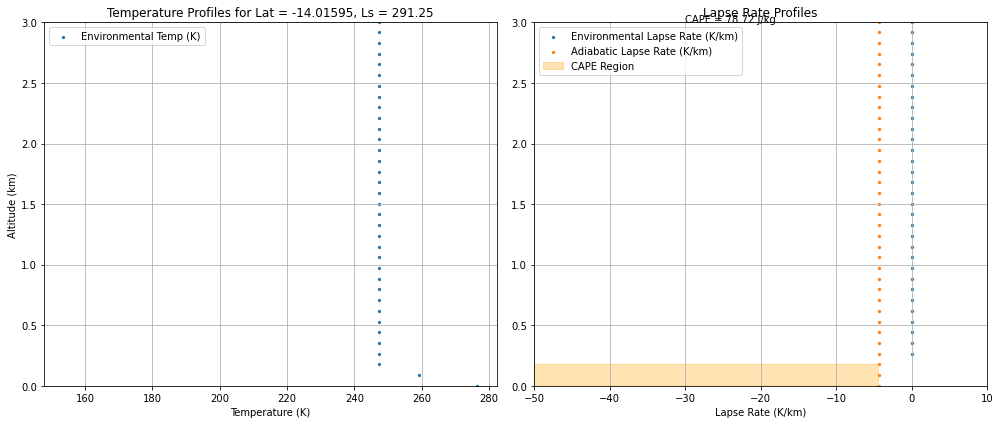

In [108]:
import random
# Randomly select a few profiles to plot (e.g., 5 profiles)
sample_size = 5
sampled_profiles = random.sample(valid_profiles, min(sample_size, len(valid_profiles)))

# Plot each sampled profile
for z_profile, temp_profile, lfc, el, cape, latitude, ls, surface_temp in sampled_profiles:
    # Generate the parcel temperature profile for plotting
    z_profile_m = z_profile * 1000
    print(z_profile_m[0])
    parcel_temp_profile = surface_temp - (dry_adiabatic_lapse_rate * z_profile_m)
    
    plot_profiles(z_profile, temp_profile, parcel_temp_profile, lfc, el, dry_adiabatic_lapse_rate, latitude, ls, cape)

In [109]:
data_cape = {'LS': df_30_surftemp_all.LS, 'Latitude': df_30_surftemp_all.SCENELATITUDE, 'SurfaceTemp': df_30_surftemp_all.SURFACETEMPERATURE, 'LFC': lfc_alt, 'EL': el_alt, 'CAPE': cape_value, 'dust_devil': dust_devil_heat}

In [110]:
df_cape = pd.DataFrame(data_cape)

In [111]:
binx = np.arange(0, 361, 1)

biny = np.arange(-90, 91, 1) #latitude bin edges

In [112]:
x = df_cape.LS
y = df_cape.Latitude
values = df_cape.CAPE
values_EL = df_cape.EL
values_DD = df_cape.dust_devil

returns_CAPE = stats.binned_statistic_2d(x, y, values, 'mean', bins=[binx, biny])
returns_EL = stats.binned_statistic_2d(x, y, values_EL, 'mean', bins=[binx, biny])
returns_DD = stats.binned_statistic_2d(x, y, values_DD, 'mean', bins=[binx, biny])

In [113]:
del df_cape

In [114]:
#np.save('MY30_CAPE_sorted', returns_CAPE.statistic.T)
#np.save('MY30_CAPE_EL_sorted', returns_EL.statistic.T)
#np.save('MY30_dustdevil_sorted', returns_DD.statistic.T)